In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# rotation object can be defined from vec, quat, matrix
r = R.from_rotvec(np.pi/2 * np.array([0, 0, 1]))
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)])
r = R.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

# rotation object can be converted to vec, quat, matrix
r.as_rotvec()
r.as_quat()
r.as_euler('zyx', degrees=True)

# possible to invert rotation
r1 = R.from_euler('z', [90, 45], degrees=True)
r2 = r1.inv()
r2.as_euler('zyx', degrees=True)


array([[-90.,   0.,  -0.],
       [-45.,   0.,  -0.]])

# Rotation Plot Example

In [3]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import numpy as np


def plot_rotated_axes(ax, r, name=None, offset=(0, 0, 0), scale=1):
    colors = ("#FF6666", "#005533", "#1199EE")  # Colorblind-safe RGB
    loc = np.array([offset, offset])
    
    for i, (axis, c) in enumerate(zip((ax.xaxis, ax.yaxis, ax.zaxis), colors)):
        axlabel = axis.axis_name
        axis.set_label_text(axlabel)
        axis.label.set_color(c)
        axis.line.set_color(c)
        axis.set_tick_params(colors=c)
        
        line = np.zeros((2, 3))
        line[1, i] = scale
        line_rot = r.apply(line)
        line_plot = line_rot + loc
        
        ax.plot(line_plot[:, 0], line_plot[:, 1], line_plot[:, 2], c)
        text_loc = line[1]*1.2
        text_loc_rot = r.apply(text_loc)
        text_plot = text_loc_rot + loc[0]
        
        ax.text(*text_plot, axlabel.upper(), color=c,
                va="center", ha="center")
    ax.text(*offset, name, color="k", va="center", ha="center",
            bbox={"fc": "w", "alpha": 0.8, "boxstyle": "circle"})

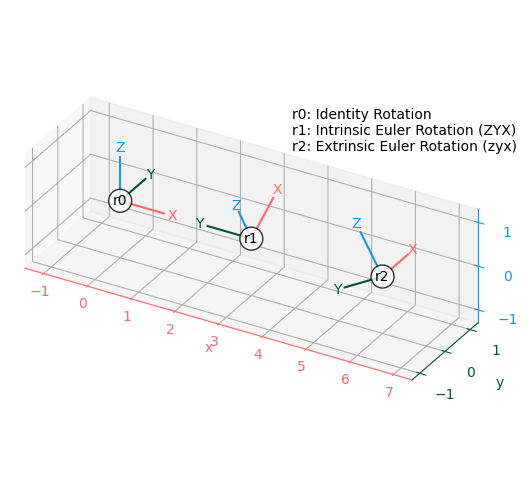

In [4]:
r0 = R.identity()
r1 = R.from_euler("ZYX", [90, -30, 0], degrees=True)  # intrinsic
r2 = R.from_euler("zyx", [90, -30, 0], degrees=True)  # extrinsic

ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes(ax, r0, name="r0", offset=(0, 0, 0))
plot_rotated_axes(ax, r1, name="r1", offset=(3, 0, 0))
plot_rotated_axes(ax, r2, name="r2", offset=(6, 0, 0))
_ = ax.annotate(
    "r0: Identity Rotation\n"
    "r1: Intrinsic Euler Rotation (ZYX)\n"
    "r2: Extrinsic Euler Rotation (zyx)",
    xy=(0.6, 0.7), xycoords="axes fraction", ha="left"
)

ax.set(xlim=(-1.25, 7.25), ylim=(-1.25, 1.25), zlim=(-1.25, 1.25))
ax.set(xticks=range(-1, 8), yticks=[-1, 0, 1], zticks=[-1, 0, 1])
ax.set_aspect("equal", adjustable="box")
ax.figure.set_size_inches(6, 5)
plt.tight_layout()
plt.show()

## rotation and Position of HMD & HMD w.r.t HMD1

In [15]:
import os, csv, pickle, gzip, torch
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output

#=======================================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)

spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

file_name = "0814-f18"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

open gzip


In [28]:
# 1. read necessary tensors (Y, hmd, hmd1, params)
# 2. input sIdx fIdx and draw
# 3. drawing animation
# 4. getting pos and rotation tensor for all frames in file



def get_y_hmd_hmd1_tensors(ffile):
    list_y = []
    list_hmd = []
    list_hmd1 = []
    for sIdx in range(24):
        _,trimY,_,_, trimHmd,trimHmd1,_,_,_ = ffile[sIdx]    
        list_y.append(trimY)
        list_hmd.append(trimHmd)
        list_hmd1.append(trimHmd1)
    return list_y, list_hmd, list_hmd1

def draw_hmd_hmd1_file(list_hmd, list_hmd1):
    sIdx = int(input("sIdx to draw hmd: "))
    fIdx = int(input("fIdx to draw hmd rot: "))
    draw_pos_rotation(trimHmd[sIdx][fIdx])
    draw_pos_rotation(trimHmd1[sIdx][fIdx])
    return
    
def draw_pos_rotation_animation(tensor):
    """
    func: draw rotation animation from file tensor
    input: tensor=[f,4,4]
    """
    
    
    
    print(tensor.shape)
    

    

def return_pos_rot_list(r, name=None, offset=(0, 0, 0), scale=1):
    pos_list = []
    rot_list = []
    
    colors = ("#FF6666", "#005533", "#1199EE")  # Colorblind-safe RGB
    loc = np.array([offset, offset])    
    for i, (axis, c) in enumerate(zip((ax.xaxis, ax.yaxis, ax.zaxis), colors)):
        axlabel = axis.axis_name
        axis.set_label_text(axlabel)
        axis.label.set_color(c)
        axis.line.set_color(c)
        axis.set_tick_params(colors=c)
        
        line = np.zeros((2, 3))
        line[1, i] = scale
        line_rot = r.apply(line)
        line_plot = line_rot + loc
        
        ax.plot(line_plot[:, 0], line_plot[:, 1], line_plot[:, 2], c)
        text_loc = line[1]*1.2
        text_loc_rot = r.apply(text_loc)
        text_plot = text_loc_rot + loc[0]
        
        ax.text(*text_plot, axlabel.upper(), color=c,
                va="center", ha="center")
    ax.text(*offset, name, color="k", va="center", ha="center",
            bbox={"fc": "w", "alpha": 0.8, "boxstyle": "circle"})    
    

In [29]:
trimY, trimHmd, trimHmd1 = get_y_hmd_hmd1_tensors(ffile)
draw_hmd_hmd1_file(trimHmd, trimHmd1)

sIdx to draw hmd:  0
fIdx to draw hmd rot:  0


torch.Size([533, 4, 4])
torch.Size([533, 4, 4])
